In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from matplotlib.patches import ConnectionPatch
from scipy.stats import pearsonr
from scipy import stats, signal
from loading import load_session_data
from target import build_tgt_matrix, get_spike_counts, build_silence_and_noise_events,\
        get_idxs_of_event_periods, build_silence_matrix, get_spike_times_at
from hallucinations import get_pop_resp_profile_mx

np.set_printoptions(suppress=True)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [109]:
# all A1
sessions_1 = [s for s in selected_009265.keys()]
sessions_1.sort()
sessions_2 = [s for s in selected_009266.keys()]
sessions_2.sort()
all_A1 = sessions_1[5:-2] + sessions_2

# All PPC
sessions_1 = [s for s in selected_008229.keys()]
sessions_1.sort()
sessions_2 = [s for s in selected_009266.keys()]
sessions_2.sort()
sessions_3 = [s for s in selected_009265.keys()]
sessions_3.sort()
all_PPC = sessions_1 + sessions_2[:-5] + sessions_3[5:-2]

# all HPC
sessions_1 = [s for s in selected_009266.keys()]
sessions_1.sort()
all_HPC = sessions_1[-5:]


selected = all_HPC
selected

['009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

In [110]:
# build response profile matrix for MANY sessions
hw, bc = 0.25, 31
bins = np.linspace(-hw, hw, bc)

profile_mx = []
for session in selected:
    animal      = session.split('_')[0]
    h5_file     = os.path.join(source, animal, session, session + '.h5')
    
    with h5py.File(h5_file, 'r') as f:
        for i, unit_name in enumerate(f['units']):
            # area filter
            if int(unit_name[0]) < 3:
                continue

            event_name = 'silence'  #'silence'
            shuffled = np.array(f['units'][unit_name]['psth_shuffled_micro_in_%s' % event_name])
            profiles = np.array(f['units'][unit_name]['psth_profiles_%s' % event_name])

            fr_mean = shuffled[:, 1]
            fr_std  = shuffled[:, 2]
            fr_prof = profiles.mean(axis=0)
            non_sign_idxs = np.where( (fr_prof > shuffled[:, 3]) & (fr_prof < shuffled[:, 4]) )[0]
            #non_sign_idxs = np.where( (fr_prof > 1.2*shuffled[:, 3]) & (fr_prof < 0.8*shuffled[:, 4]) )[0]
            
            resp_profile = (fr_prof - fr_mean)/fr_std  # z-scored
            resp_profile[non_sign_idxs] = 0  # clean non-significant bins
            profile_mx.append( resp_profile )
            
profile_mx = np.array(profile_mx)
profile_mx.shape

(159, 30)

In [111]:
# no significant bins
no_sign_bins = np.array([(rec[15:] == 0).all() for rec in profile_mx]).sum()
sign_bins    = np.array([(rec[15:] != 0).any() for rec in profile_mx]).sum()

# high bin count
high_sign_bins = np.array([(rec[15:] > 0).sum() for rec in profile_mx])

# low bin count
low_sign_bins = np.array([(rec[15:] < 0).sum() for rec in profile_mx])

Text(0.5, 1.0, 'HPC (159 units)')

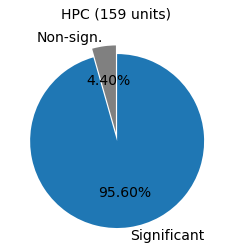

In [113]:
# just a pie charts
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
labels  = ['Non-sign.', 'Significant']
sizes   = [no_sign_bins, sign_bins]
colors  = ['gray', 'tab:blue']
        
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%', shadow=False, \
       startangle=90, textprops={'size': 14}, colors=colors)
ax.set_title('HPC (%d units)' % int(no_sign_bins + sign_bins), fontsize=14)

(array([185.,  75.,  23.,   3.,   0.,   0.,   0.,   1.,   0.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 9 artists>)

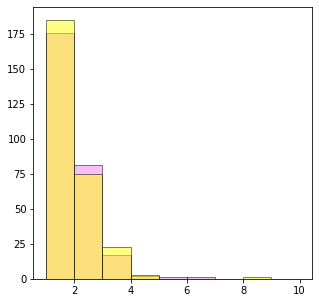

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.hist(high_sign_bins, bins=np.linspace(1, 10, 10), edgecolor='black', color='violet', alpha=0.5, label='All')
ax.hist(low_sign_bins, bins=np.linspace(1, 10, 10), edgecolor='black', color='yellow', alpha=0.5, label='All')

## Count number of bins

In [18]:
# for silence
collected = []
for session in sessions[:1]:
    animal      = session.split('_')[0]
    h5_file     = os.path.join(source, animal, session, session + '.h5')
    
    with h5py.File(h5_file, 'r') as f:
        unit_names = list(f['units'])
        
    max_sign_bins = np.zeros(len(unit_names))
    for i, unit_name in enumerate(unit_names[:10]):
        if int(unit_name[0]) < 0:
            continue

        with h5py.File(h5_file, 'r') as f:
            shuffled_sil = np.array(f['units'][unit_name]['psth_shuffled_micro_in_silence'])
            profiles = np.array(f['units'][unit_name]['psth_profiles_silence'])

        # for silence
        fr_sil_mean = shuffled_sil[:, 1]
        fr_sil_std  = shuffled_sil[:, 2]
        fr_sil_prof = profiles.mean(axis=0)
        prof_sil_z = (fr_sil_prof - fr_sil_mean)/fr_sil_std  # z-scored
        #prof_sil_z /= np.max(np.abs(prof_sil_z), axis=0)      # put bw -1 and 1

        # significant bins
        idxs_non_sign = np.where((fr_sil_prof > shuffled_sil[:, 3]) & (fr_sil_prof < shuffled_sil[:, 4]))[0]
        idxs_sign = np.array([x for x in range(31 - 1) if x not in idxs_non_sign])
        if len(idxs_sign[idxs_sign > 14]) > 0:
            max_sign_bins[i] = fr_sil_prof[idxs_sign[idxs_sign > 14]].argmax()

    collected.append(max_sign_bins)
collected = np.array([item for sublist in collected for item in sublist])